<a href="https://colab.research.google.com/github/Anmol42/IDP-sem4/blob/vae/notebooks/GAN_colorize_with_validation_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataloader import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/Datasets/flowers.zip ## Silenced the unzip action

In [4]:
from skimage.io import imread_collection
path = "/content/flowers/*/*jpg"
train_ds = imread_collection(path)

In [8]:
import random
random.shuffle(list(train_ds))

In [9]:
from skimage.color import rgb2lab,lab2rgb
from skimage.transform import resize
images= torch.zeros(len(train_ds),3,128,128)
for i,im in enumerate(train_ds):
  im = resize(im, (128,128,3),
                       anti_aliasing=True)
  image = rgb2lab(im)
  image = torch.Tensor(image)
  image = image.permute(2,0,1)
  #print(i)
  images[i]=image
print(images.max(),images.min())
images[:,0] = images[:,0]/100
images[:,1:] = images[:,1:]/128
print(images.max(),images.min())
batch_size = 100

tensor(100.) tensor(-105.9237)
tensor(1.) tensor(-0.8275)


In [39]:
## generator model
class generator(nn.Module):
    def __init__(self):         # z is input noise
        super(generator,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,8,kernel_size=3,padding=1,stride=2),
                                   nn.BatchNorm2d(8),
        nn.LeakyReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(8,16,kernel_size=5,padding=2,stride=2),
                                   nn.BatchNorm2d(16),
        nn.LeakyReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1,stride=2),
                                   nn.BatchNorm2d(32),
        nn.LeakyReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(32,64,kernel_size=5,padding=2,stride=2),    #size is 8x8 at this point
        nn.LeakyReLU())
        # BottleNeck
        self.bottleneck = nn.Sequential(nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
                                        nn.LeakyReLU())     # size 4x4
        self.deconv7 = nn.Sequential(nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv6 = nn.Sequential(nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv5 = nn.Sequential(nn.ConvTranspose2d(64,64,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(8,2,kernel_size=4,stride=2,padding=1),
        nn.Tanh())
        self.linear = nn.Linear(128*4*4,512)

    def forward(self,xb,z):
        out1 = self.conv1(xb)
        #print("out1 ",out1.shape)
        out2 = self.conv2(out1)
        #print("out 2",out2.shape)
        out3 = self.conv3(out2)
        #print("out3 ",out3.shape)
        out4 = self.conv4(out3)
        #print("after conv4",out4.shape)
        out5 = self.bottleneck(out4)
        out6 = out5.view(z.shape[0],-1)         # Replaced hardcoded batch_size
        #print("after applying view",out6.shape)
        out6 = self.linear(out6) #we get 256 size vector
        mu = out6[:,:256]
        sig = torch.abs(out6[:,256:])
        #print(out6.shape,mu.shape,sig.shape)
        noise = z*sig + mu
        #print("noise shape",noise.shape)

        out5 = self.deconv7(noise.unsqueeze(2).unsqueeze(2))
        #print("after deconv7",out5.shape)
        out5 = self.deconv6(out5)
        #print("after deconv3",out4.shape)
        out5 = self.deconv5(out5)
        out5 = self.deconv4(out5)
        out5 = self.deconv3(out5)
        out5 = self.deconv2(out5)
        out5 = self.deconv1(out5)
        #print("after deconv1",out5.shape)
        #out5 = self.deconv1(out5)
        #print("after deconv1",out4.shape)
        return torch.cat((xb,out5),1)
        """"""

In [40]:
## discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,8,kernel_size=3,stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(8,16,kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.linear1 = nn.Linear(64*25,128)
        self.linear2 = nn.Linear(128,1)
    def forward(self,x):
        out = self.network(x)
        out = self.linear1(out)
        out = self.linear2(out)
        out = torch.sigmoid(out)
        return out

In [41]:
gen_model = generator()
dis_model = discriminator()

In [42]:
train_dl = DataLoader(images[:3500],batch_size,shuffle=True,pin_memory=True,num_workers=2)
val_dl = DataLoader(images[3500:4000],batch_size, num_workers=2,pin_memory=True)
test_dl = DataLoader(images[4000:],batch_size,num_workers=2)

In [43]:
bceloss = nn.BCEWithLogitsLoss()
#minimise this # t is whether the image is fake or real; x is prob vect of patches being real/fake.
def loss_inf(x,t):    # probability vector from discriminator as input
    return int(t)*(bceloss(x,torch.ones_like(x))) + (1-int(t))*bceloss(x,torch.zeros_like(x))

In [44]:
l1loss = nn.L1Loss()
def gen_loss(x,y):
    return l1loss(x,y)

In [45]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [46]:
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')
test_dl = DeviceDataLoader(test_dl,'cuda')
gen_model.to('cuda')
dis_model.to('cuda')

discriminator(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (linear1): Linear(in_features=1600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [47]:
def get_item(batch_size=100):
    pass
import torch.autograd as auto
auto.set_detect_anomaly(True)

In [62]:
def fit(epochs,lr_g,lr_d,generator,discriminator,batch_size,opt_func=torch.optim.Adam):
    gen_optimize = opt_func(generator.parameters(),lr_g)
    dis_optimize = opt_func(discriminator.parameters(),lr_d)
    train_g_history,train_d_history = [],[]
    val_g_history, val_d_history = [],[]
    for epoch in range(epochs):
        epoch_loss_g = torch.zeros(1).to('cuda')
        epoch_loss_d = torch.zeros(1).to('cuda')
        noise = torch.randn(batch_size,256).to('cuda')
        for batch in train_dl:
            for i in range(5):
              out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
              real_score = discriminator(batch) # how real is the og input image
              fake_score = discriminator(out) # how real is the generated image  
              loss_d = loss_inf(real_score,1) + loss_inf(fake_score,0)# discriminator
              #print(loss_d.item())
              loss_d.backward()
              dis_optimize.zero_grad()
              dis_optimize.step()
            
            out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
            real_score = discriminator(batch) # how real is the og input image
            fake_score = discriminator(out) # how real is the generated image  

            loss_g = 2*gen_loss(out,batch) + loss_inf(fake_score,1)
            loss_g.backward()
            gen_optimize.step()
            gen_optimize.zero_grad()

            with torch.no_grad():
              epoch_loss_g += loss_g
              epoch_loss_d += loss_d
        train_d_history.append(epoch_loss_d)
        train_g_history.append(epoch_loss_g)
        epoch_loss_g = 0
        epoch_loss_d = 0
        for batch in val_dl:
            with torch.no_grad():
              out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
              real_score = discriminator(batch) # how real is the og input image
              fake_score = discriminator(out) # how real is the generated image  
              loss_d = loss_inf(real_score,1) + loss_inf(fake_score,0)# discriminator
              loss_g = 2*gen_loss(out,batch) + loss_inf(fake_score,1)
              epoch_loss_g += loss_g
              epoch_loss_d += loss_d

        
        val_g_history.append(epoch_loss_g.item())
        val_d_history.append(epoch_loss_d.item())
        if epoch % 10 == 0:
            print("Gen Epoch Loss",epoch_loss_g)
            print("Discriminator Epoch loss",epoch_loss_d)
    return train_d_history,train_g_history,val_d_history,val_g_history


In [63]:
loss_h = fit(30,0.001,0.001,gen_model,dis_model,batch_size,opt_func=torch.optim.Adam)

Gen Epoch Loss tensor(3.3237, device='cuda:0')
Discriminator Epoch loss tensor(7.2418, device='cuda:0')
Gen Epoch Loss tensor(3.3248, device='cuda:0')
Discriminator Epoch loss tensor(7.2417, device='cuda:0')
Gen Epoch Loss tensor(3.3274, device='cuda:0')
Discriminator Epoch loss tensor(7.2417, device='cuda:0')


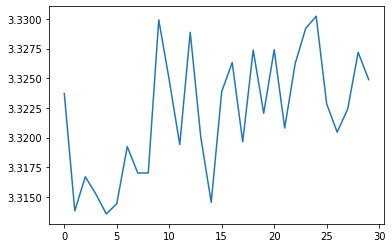

In [67]:
import matplotlib.pyplot as plt
plt.plot(loss_h[3])

In [131]:
from skimage.color import rgb2lab,lab2rgb
def tensor_to_pic(tensor : torch.Tensor) -> np.ndarray:
    tensor[0] *=  100
    tensor[1:]*=  128
    image = tensor.permute(1,2,0).detach().cpu().numpy()
    image = lab2rgb(image)
    return image

def show_images(n,dataset = images,gen=gen_model,dis=dis_model) -> None:
  gen_model.eval()
  dis_model.eval()
  z = torch.randn(1,256).to('cuda')
  #z = torch.ones_like(z)
  image_tensor = dataset[n].to('cuda')
  gen_tensor = gen(image_tensor[0].unsqueeze(0).unsqueeze(0),z)[0]
  image = tensor_to_pic(image_tensor)
  #print(torch.sum(gen_tensor))
  gen_image = tensor_to_pic(gen_tensor)
  to_be_shown = np.concatenate((gen_image,image),axis=1)
  plt.figure(figsize=(9,9))
  plt.imshow(to_be_shown)
  plt.show()
  


tensor(9931.8047, device='cuda:0', grad_fn=<SumBackward0>)


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


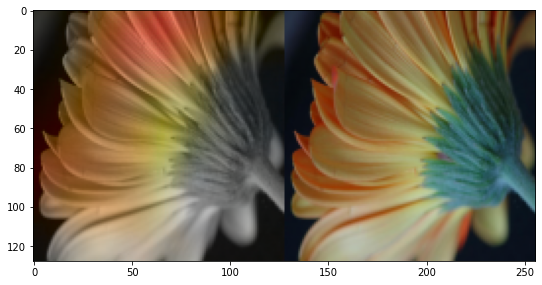

In [141]:
show_images(2)      ## Shows generated and coloured images side by side

# The lower section to be removed

In [ ]:
from skimage.color import rgb2lab,lab2rgb
gen_model.eval()
dis_model.eval()
n = 4200
z = torch.randn(100,128).to('cuda')
im = images[n:n+100,0].unsqueeze(1).to('cuda')
fake = gen_model(im,z)
print(dis_model(fake))

print(fake[0].shape)
fake_1 = fake[0].permute(1,2,0).detach().cpu().numpy()
print(fake_1.shape)
fake_1[:,:,0] *=100
fake_1[:,:,1:] *= 128
fake_1 =lab2rgb(fake_1)
import matplotlib.pyplot as plt
plt.imshow(fake_1)

torch.Size([3, 128, 128])
(128, 128, 3)


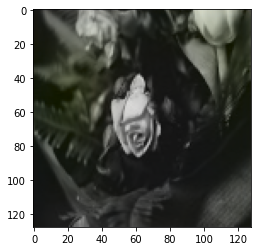

In [ ]:
print(fake[3].shape)
fake_2 = fake[3].permute(1,2,0).detach().cpu().numpy()
print(fake_2.shape)
fake_2[:,:,0] *=100
fake_2[:,:,1:] *= 128
fake_2 =lab2rgb(fake_2)
import matplotlib.pyplot as plt
plt.imshow(fake_2)

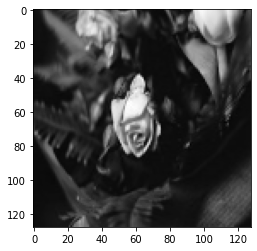

In [ ]:
from skimage.color import rgb2gray
fake_2 = rgb2gray(fake_2) 
plt.imshow(fake_2,cmap='gray')

tensor([[0.5086]], device='cuda:0', grad_fn=<SigmoidBackward>)
(128, 128, 3)


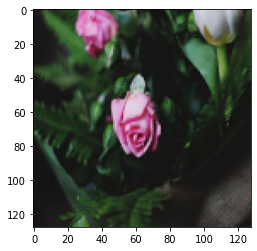

In [ ]:
#print(dis_model(images[n].unsqueeze(0).to('cuda')))
real=images[4203]
print(dis_model(real.unsqueeze(0).cuda(0)))
real[0] *= 100
real[1:] *= 128
real = real.permute(1,2,0).cpu().detach().numpy()

print(real.shape)
real =lab2rgb(real)
import matplotlib.pyplot as plt
plt.imshow(real)

In [ ]:
torch.save_dict_